In [3]:
from pystac_client import Client
import geopandas as gpd
from datetime import datetime, UTC
import stackstac
import xarray as xr
from shapely.geometry import Point
from rasterio.errors import RasterioIOError
from planetary_computer import sign_inplace
import matplotlib.pyplot as plt

<Axes: >

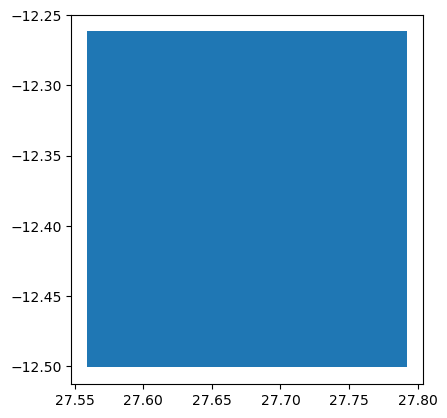

In [4]:
# Connect to Planetary Computer STAC
stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Load AOI from GeoJSON file
aoi_path = r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\Archive\KoboldData\zambia_aoi_small.geojson"
aoi_gdf = gpd.read_file(aoi_path)

# Reproject to WGS84 if needed
if aoi_gdf.crs != "EPSG:4326":
    aoi_gdf = aoi_gdf.to_crs("EPSG:4326")

aoi_gdf.plot()

In [ ]:
# Search STAC for low-cloud Sentinel-2 L2A items over AOI

# Broad date range — Sentinel-2 L2A available since mid-2017
start_date = "2017-06-28"
end_date = datetime.now(UTC).date().isoformat()

# Query STAC for clean Sentinel-2 L2A items
search = stac.search(
    collections=["sentinel-2-l2a"],
    intersects=aoi_gdf.geometry[0].__geo_interface__,
    datetime=f"{start_date}/{end_date}",
    query={"eo:cloud_cover": {"lt": 10}},  # low-cloud only
    sortby=["eo:cloud_cover"],  # sort by best quality
)

items = list(search.items())
print(f"Found {len(items)} items")

# Print out all property keys on the first item to view available metadata
props = items[0].properties
for k in sorted(props):
    print(k)

Found 300 items
constellation
datetime
eo:cloud_cover
instruments
platform
proj:code
s2:cloud_shadow_percentage
s2:datastrip_id
s2:datatake_id
s2:datatake_type
s2:degraded_msi_data_percentage
s2:generation_time
s2:granule_id
s2:high_proba_clouds_percentage
s2:mean_solar_azimuth
s2:mean_solar_zenith
s2:medium_proba_clouds_percentage
s2:mgrs_tile
s2:nodata_pixel_percentage
s2:not_vegetated_percentage
s2:processing_baseline
s2:product_type
s2:product_uri
s2:reflectance_conversion_factor
s2:saturated_defective_pixel_percentage
s2:snow_ice_percentage
s2:thin_cirrus_percentage
s2:unclassified_percentage
s2:vegetation_percentage
s2:water_percentage
sat:orbit_state
sat:relative_orbit


In [ ]:
# Filter for S2A scenes, set EPSG, and stack selected bands at 10m resolution

# Keep only S2A scenes and sign their URLs
s2a_items = [it for it in items[:20] if it.id.startswith("S2A")]
for it in s2a_items:
    sign_inplace(it)
print("Using these S2A items:", [it.id for it in s2a_items])

# Try EPSG from first item 
item0 = s2a_items[0]
epsg = None
try:
    epsg = item0.assets["B02"].extra_fields["proj:epsg"]
    print(f"Using EPSG from first item: {epsg}")
except KeyError:
    pass

# Fall back to AOI centroid 
if epsg is None:
    centroid: Point = aoi_gdf.geometry[0].centroid
    lon, lat = centroid.x, centroid.y
    zone = int((lon + 180) / 6) + 1
    epsg = 32600 + zone if lat >= 0 else 32700 + zone
    print(f"Using EPSG from AOI centroid: {epsg}")

# Stack normally, resolution=10m for all bands
stack = stackstac.stack(
    s2a_items,
    assets=["B02", "B03", "B04", "B08", "B11", "B12", "SCL"],
    resolution=10, # 10m resolution for all bands
    epsg=epsg,
    chunksize=2048,
    bounds_latlon=aoi_gdf.total_bounds,
    dtype="float64",
    rescale=True,
    errors_as_nodata=[RasterioIOError, RuntimeError],
)

stack

Using these S2A items: ['S2A_MSIL2A_20240610T080611_R078_T35LNG_20240610T142010', 'S2A_MSIL2A_20241018T080941_R078_T35LNG_20241018T120345', 'S2A_MSIL2A_20240928T080721_R078_T35LNG_20240928T120855', 'S2A_MSIL2A_20240221T080941_R078_T35LNG_20240221T131108']
Using EPSG from AOI centroid: 32735


<xarray.DataArray 'stackstac-40a2b38fd8327fb16e1604d4b0a53eb5' (time: 4,
                                                                band: 7,
                                                                y: 2655, x: 2545)> Size: 2GB
dask.array<fetch_raster_window, shape=(4, 7, 2655, 2545), dtype=float64, chunksize=(1, 1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 32B 2024-0...
    id                                       (time) <U54 864B 'S2A_MSIL2A_202...
  * band                                     (band) <U3 84B 'B02' ... 'SCL'
  * x                                        (x) float64 20kB 5.607e+05 ... 5...
  * y                                        (y) float64 21kB 8.644e+06 ... 8...
    s2:granule_id                            (time) <U62 992B 'S2A_OPER_MSI_L...
    ...                                       ...
    title                                    (band) <U29 812B 'Band 2 - Blue ...
    gsd                                      (band) float64 56B 10.0 ... 20.0
    common_name                              (band) object 56B 'blue' ... None
    center_wavelength                        (band) object 56B 0.49 ... None
    full_width_half_max                      (band) object 56B 0.098 ... None
    epsg                                     int64 8B 32735
Attributes:
    spec:        RasterSpec(epsg=32735, bounds=(560740, 8617920, 586190, 8644...
    crs:         epsg:32735
    transform:   | 10.00, 0.00, 560740.00|\n| 0.00,-10.00, 8644470.00|\n| 0.0...
    resolution:  10

In [ ]:
# Histogram‐match with dask_gufunc_kwargs

from skimage.exposure import match_histograms
import xarray as xr

# Rechunk so band, y, x are single chunks
stack_small = stack.chunk({"band": -1, "y": -1, "x": -1})

# Reference = first clean scene (no time dim)
ref = (
    stack_small.isel(time=0)
    .sel(band=["B02", "B03", "B04", "B08", "B11", "B12"])
    .chunk({"band": -1, "y": -1, "x": -1})
)


def match_to_ref(scene, ref):
    return xr.apply_ufunc(
        match_histograms,
        scene,
        ref,
        input_core_dims=[["band", "y", "x"], ["band", "y", "x"]],
        output_core_dims=[["band", "y", "x"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[scene.dtype],
        dask_gufunc_kwargs={
            "allow_rechunk": True,
            "output_sizes": {
                "band": scene.sizes["band"],
                "y": scene.sizes["y"],
                "x": scene.sizes["x"],
            },
        },
    )


# Build the normalized stack, re-adding time
matched = []
for i, t in enumerate(stack_small.time.values):
    scene = stack_small.isel(time=i).sel(band=ref.band)
    scene = scene.chunk({"band": -1, "y": -1, "x": -1})
    m = match_to_ref(scene, ref)
    m = m.expand_dims(time=[t])
    matched.append(m)


stack_norm = xr.concat(matched, dim="time")

In [ ]:
# Mask invalid pixels using SCL and compute median composite over time


# Ensure your original stack is rechunked so SCL aligns
stack_small = stack.chunk({"band": -1, "y": -1, "x": -1})

# Extract the Scene Classification Layer and build a “valid” mask
scl = stack_small.sel(band="SCL")
valid = scl.isin([4, 5, 6])  # vegetation=4, bare soil=5, water=6

# Apply mask to the histogram-matched reflectance and composite

clean = stack_norm.where(valid)       # holds only the reflectance bands (no SCL)
composite = clean.median(dim="time")

# Inspect the composite
composite

<xarray.DataArray 'stackstac-40a2b38fd8327fb16e1604d4b0a53eb5' (band: 6,
                                                                y: 2655, x: 2545)> Size: 324MB
dask.array<nanmedian, shape=(6, 2655, 2545), dtype=float64, chunksize=(2, 1478, 1417), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * band                                     (band) <U3 72B 'B02' ... 'B12'
  * x                                        (x) float64 20kB 5.607e+05 ... 5...
  * y                                        (y) float64 21kB 8.644e+06 ... 8...
    sat:relative_orbit                       int64 8B 78
    s2:mgrs_tile                             <U5 20B '35LNG'
    constellation                            <U10 40B 'Sentinel 2'
    ...                                       ...
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    platform                                 <U11 44B 'Sentinel-2A'
    instruments                              <U3 12B 'msi'
    proj:bbox                                object 8B {8590240.0, 8700040.0,...
    epsg                                     int64 8B 32735

In [ ]:
# Compute clay and iron oxide indices from composite bands


# Select bands
b04 = composite.sel(band="B04")
b11 = composite.sel(band="B11")
b12 = composite.sel(band="B12")

# Compute indices
clay_index = (b12 / b11).rename("clay_index")
iron_index = ((b04 - b11) / (b04 + b11)).rename("iron_index")

# Combine into one DataArray
indices = xr.concat([clay_index, iron_index], dim="band")
indices["band"] = ["clay_index", "iron_index"]

# Inspect
indices

<xarray.DataArray 'clay_index' (band: 2, y: 2655, x: 2545)> Size: 108MB
dask.array<concatenate, shape=(2, 2655, 2545), dtype=float64, chunksize=(1, 1478, 1417), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * x                                        (x) float64 20kB 5.607e+05 ... 5...
  * y                                        (y) float64 21kB 8.644e+06 ... 8...
    sat:relative_orbit                       int64 8B 78
    s2:mgrs_tile                             <U5 20B '35LNG'
    constellation                            <U10 40B 'Sentinel 2'
    proj:code                                <U10 40B 'EPSG:32735'
    ...                                       ...
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    platform                                 <U11 44B 'Sentinel-2A'
    instruments                              <U3 12B 'msi'
    proj:bbox                                object 8B {8590240.0, 8700040.0,...
    epsg                                     int64 8B 32735
  * band                                     (band) <U10 80B 'clay_index' 'ir...

In [ ]:
# Load clay and iron index arrays fully into memory for plotting

clay = indices.sel(band="clay_index").compute()
iron = indices.sel(band="iron_index").compute()

(np.float64(560735.0),
 np.float64(586185.0),
 np.float64(8617925.0),
 np.float64(8644475.0))

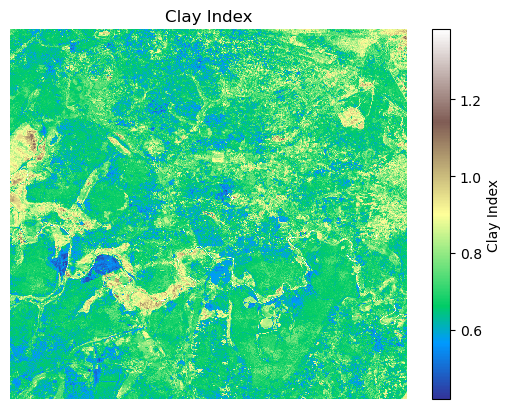

In [36]:
# Plot the clay index
clay.plot(
    cmap="terrain",
    cbar_kwargs={"label": "Clay Index"},
)
plt.title("Clay Index")
plt.axis("off")


(np.float64(560735.0),
 np.float64(586185.0),
 np.float64(8617925.0),
 np.float64(8644475.0))

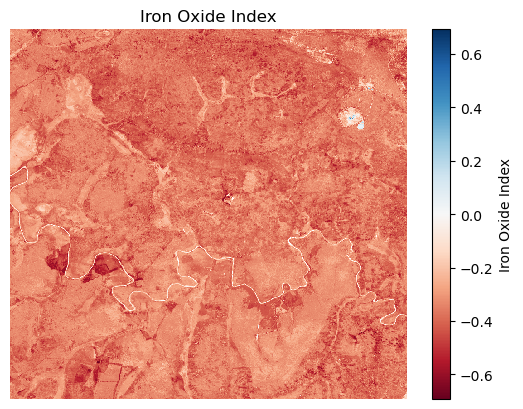

In [ ]:
# Plot the iron oxide index
iron.plot(
    cmap="RdBu",
    cbar_kwargs={"label": "Iron Oxide Index"},
)
plt.title("Iron Oxide Index")
plt.axis("off")